# Models: Collaborative Auto Encoder



[Variational AutoEncoders (VAE) with PyTorch](https://avandekleut.github.io/vae/)

[K-means, DBSCAN, GMM, Agglomerative clustering — Mastering the popular models in a segmentation problemK-means, DBSCAN, GMM, Agglomerative clustering — Mastering the popular models in a segmentation problem](https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29)


In [1]:
%load_ext autoreload
%autoreload 2
BASE_PATH      = '../..'
DATASETS_PATH  = f'{BASE_PATH}/datasets'
EMBEDDING_PATH = f'{DATASETS_PATH}/caa_user_ratings_embedings.json'

In [2]:
import sys
sys.path.append(f'{BASE_PATH}/lib')

In [3]:
import pytorch_common
pytorch_common.__version__

'0.0.23'

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader
from torch.optim      import Adam

import pytorch_common.util as pu
from pytorch_common.callbacks.output import (
    Logger,
    MetricsPlotter
)
from pytorch_common.util import (
    set_device_name,
    get_device,
    LoggerBuilder
)

import model as ml

import data.dataset as ds
import data.plot as pl
import data as dt

import logging
import random

import util as ut

## Setup

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available(), torch.__version__

(device(type='cuda', index=0), True, '1.11.0')

In [7]:
ut.set_seed(42)

## Helper Functions

In [8]:
def build_user_ratings_df(latent_space, dataset):
    user_ratings_emb_df = pd.DataFrame({
        'user_ratings_emb': [latent_space[idx] for idx in range(latent_space.shape[0])],
        'cluster': medoids_result.labels
    })
    user_ratings_emb_df['user_seq'] = user_ratings_emb_df.index
    
    id_by_seq_dict = ut.id_by_seq(dataset, 'user')
    user_ratings_emb_df['user_id']  = user_ratings_emb_df['user_seq'].apply(lambda seq: id_by_seq_dict[seq])
    return user_ratings_emb_df

In [9]:
def save_df(df, path): return df.to_json  (path, orient='records')
def load_df(path):     return pd.read_json(path, orient='records')

In [10]:
def value_counts(values: np.array):
    df = pd.DataFrame(pd.Series(values).value_counts()).reset_index()
    df = df.rename(columns={'index': 'value', 0: 'count'}) 
    return df[['value', 'count']]

In [11]:
def to_col_dict(df, key, value):
    data = df.drop_duplicates(subset=key)
    data = data[[key, value]]
    return ut.to_dict(data, key, value)

## Carga de dataset

In [12]:
dataset  = ds.MovieLensTMDBDatasetFactory.df_from_path(f'{BASE_PATH}/datasets')
train_ds = ds.CollaborativeAutoEncoderDataset(dataset)

In [13]:
movies_count = dataset.movie_seq.max() + 1
users_count  = dataset.user_seq.max() + 1

users_count, movies_count

(1885, 17611)

## Entrenamiento

In [14]:
params = Bunch({
    'lr'               : 0.0001,
    'epochs'           : 300,
    'latent_space_dim' : 100,
    'n_workers'        : 24,
    'batch_size'       : 64,
    'train'            : True
})

In [15]:
train_dl = DataLoader(
    train_ds, 
    batch_size  = params.batch_size,
    num_workers = params.n_workers,
    pin_memory  = True,
    shuffle     = True
)

In [16]:
model = ml.CollaborativeAutoEncoder(
    n_users            = users_count,
    n_item_ratings     = movies_count,
    latent_space_dim   = params.latent_space_dim
).to(pu.get_device())

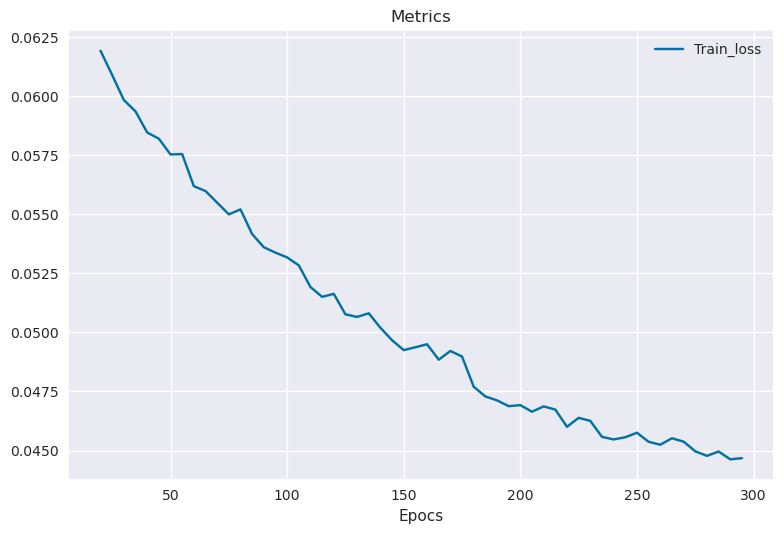

In [17]:
if params.train:
    result = model.fit(
        train_dl,
        epochs      = params.epochs,
        loss_fn     = ml.MSELossFn(),
        optimizer   = Adam(
            params = model.parameters(),
            lr     = params.lr
        ),
        callbacks   = [
            Logger(['time', 'epoch', 'train_loss']),
            MetricsPlotter(
                metrics            = ['train_loss'],
                warmup_count       = 3,
                plot_each_n_epochs = 5,
                reg_each_n_epochs  = 5
            ),
        ]
    )
    result.train_loss

In [18]:
model.save('cae-checkpoint') if params.train else model.load('cae-checkpoint')

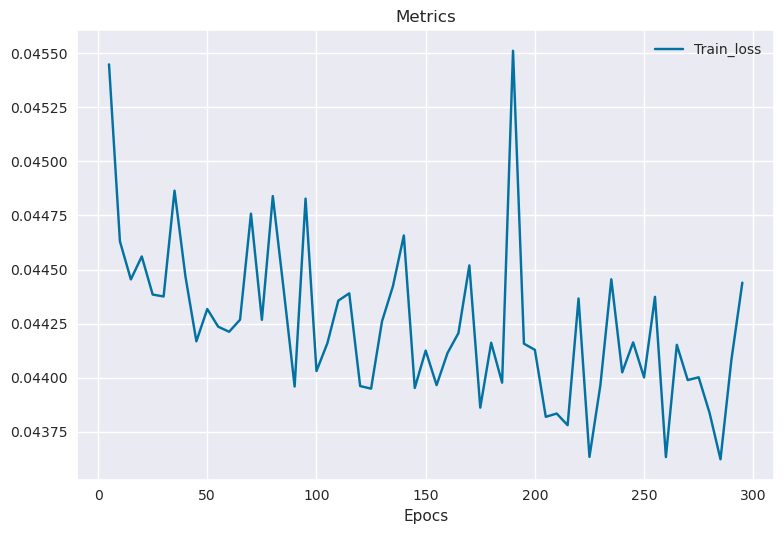

In [19]:
params = Bunch({
    'lr'               : 0.00001,
    'epochs'           : 300,
    'latent_space_dim' : 100,
    'n_workers'        : 24,
    'batch_size'       : 64,
    'train'            : True
})

if params.train:
    result = model.fit(
        train_dl,
        epochs      = params.epochs,
        loss_fn     = ml.MSELossFn(),
        optimizer   = Adam(
            params = model.parameters(),
            lr     = params.lr
        ),
        callbacks   = [
            Logger(['time', 'epoch', 'train_loss']),
            MetricsPlotter(
                metrics            = ['train_loss'],
                plot_each_n_epochs = 5,
                reg_each_n_epochs  = 5
            ),
        ]
    )
    result.train_loss

In [20]:
model.save('cae-checkpoint') if params.train else model.load('cae-checkpoint')

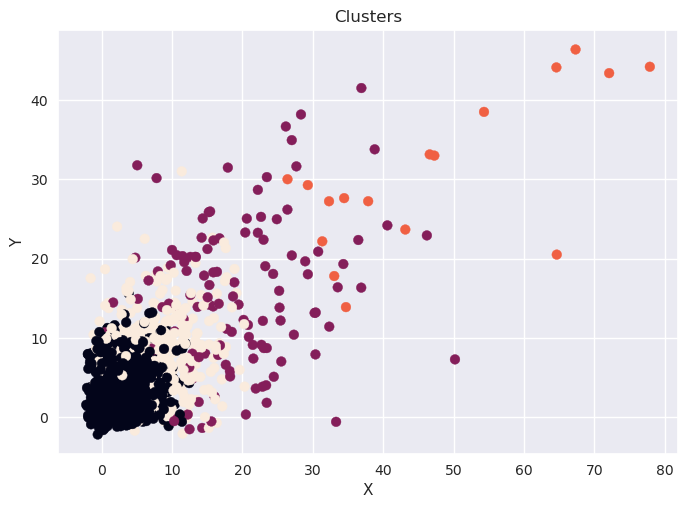

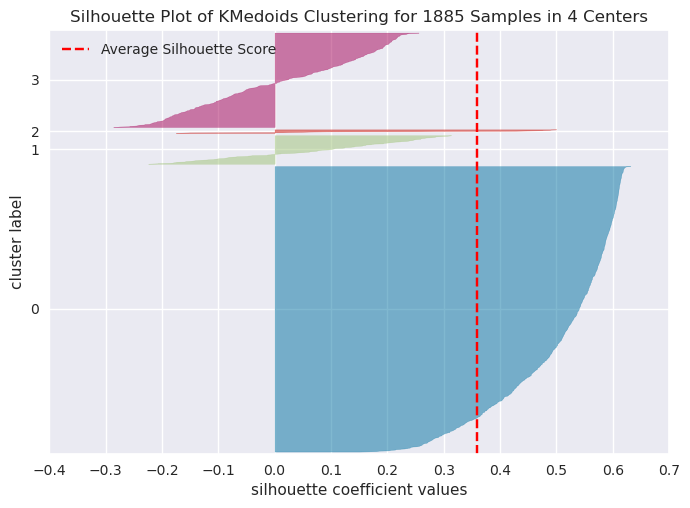

Silhouette: -0.26722025871276855


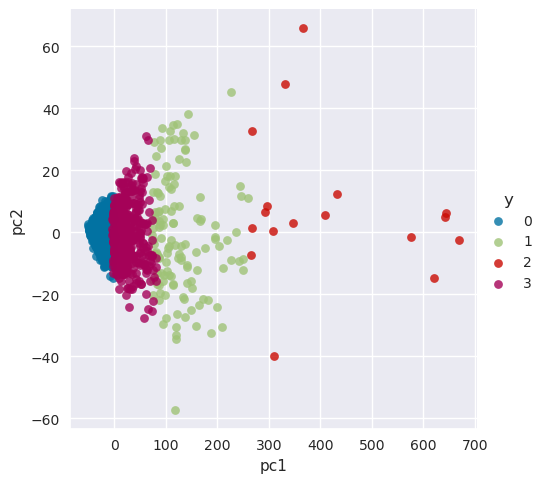

2023-03-25 16:24:07,646 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


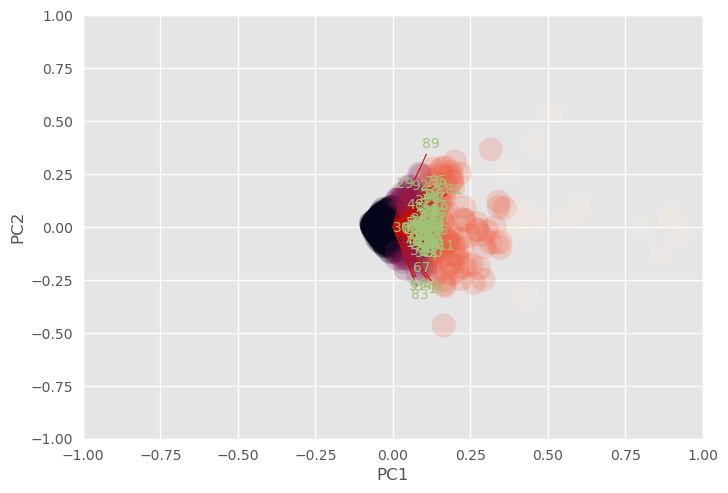

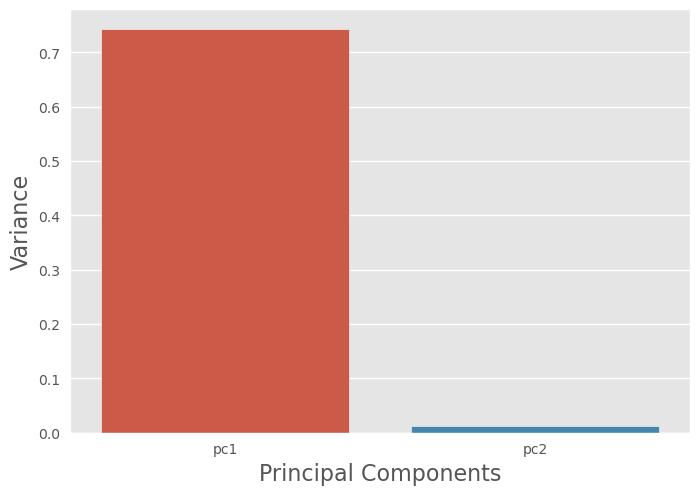

array([0.742388  , 0.01193674], dtype=float32)

In [21]:
latent_space = model.as_encoder()(train_ds)

medoids_result = ml.KMedoisClustering(n_clusters = 4) \
    .predict(latent_space) \
    .plot()

dt.PCAAnalisys \
    .make_on(
        X = pd.DataFrame(latent_space),
        y = medoids_result.labels,
        n_components = 2
    ) \
    .plot()

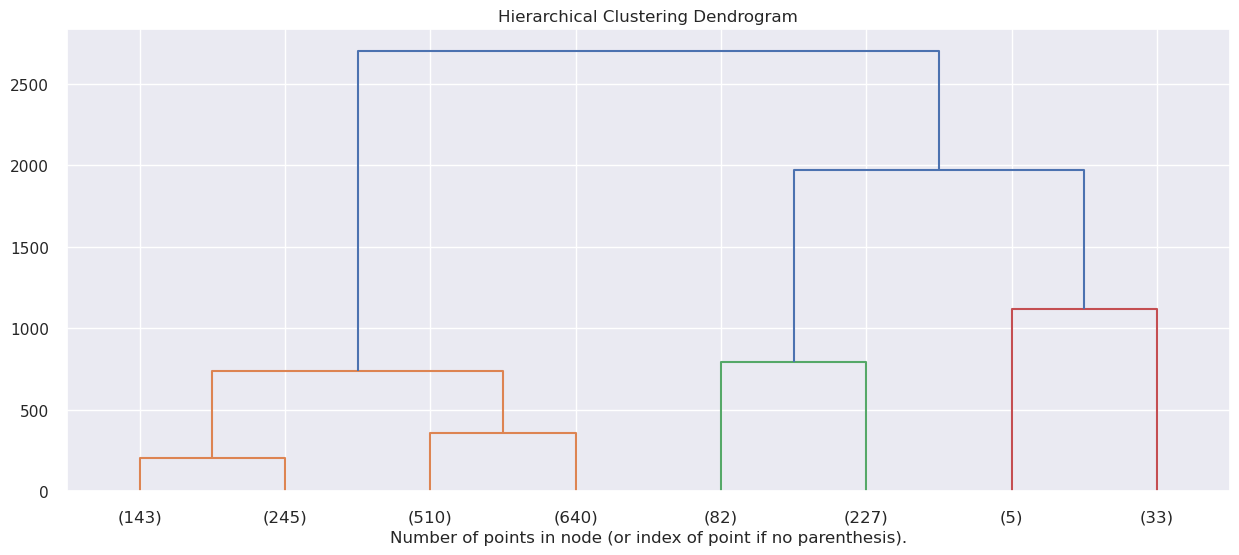

In [22]:
pl.plot_dendrogram(latent_space, max_top_levels=2)

In [23]:
user_ratings_emb_df = build_user_ratings_df(latent_space, dataset)

save_df(user_ratings_emb_df, EMBEDDING_PATH)

In [24]:
user_ratings_emb_df = load_df(EMBEDDING_PATH)

user_ratings_emb_df.head()

,user_ratings_emb,cluster,user_seq,user_id
0,"[6.6748209, 6.5374879837, 1.6621525288, 3.6301...",0,0,791
1,"[8.8991146088, 8.0371570587, 9.986073494, 6.79...",3,1,3164
2,"[33.5313453674, 16.3853378296, 38.4840965271, ...",1,2,3448
3,"[5.1812810898, 3.5207955837, 5.1428947449, 5.5...",0,3,4676
4,"[2.9796259403, 7.6019253731, 3.0340037346, 3.9...",0,4,4693


In [25]:
groups = user_ratings_emb_df.groupby(['cluster'])

movies_clusters = {}
for cluster in user_ratings_emb_df['cluster'].unique():
    df = groups.get_group(cluster)
    
    user_seqs = df['user_seq'].unique()

    ms = train_ds.data[train_ds.data['user_seq'].isin(user_seqs)]['movie_rating_emb'].values
    movie_seqs = np.concatenate([np.where(m >=3) for m in ms], axis=1).squeeze()

    if cluster not in movies_clusters:
        movies_clusters[cluster] = []

    movies_clusters[cluster].extend(movie_seqs.tolist())
    

In [26]:
genres_by_movie_seq = to_col_dict(dataset, key='movie_seq', value='movie_genres')

genres_by_cluster = {}

for cluster in user_ratings_emb_df['cluster'].unique():
    movie_seq_count = value_counts(movies_clusters[cluster])
    
    for _, row in movie_seq_count.iterrows():
        genres = genres_by_movie_seq[row['value']]
    
        if cluster not in genres_by_cluster:
            genres_by_cluster[cluster] = []

        genres_by_cluster[cluster].extend(genres * row['count'])

In [157]:
parts = []
for cluster, df in genres_by_cluster.items():
    df = value_counts(df)
    df['cluster'] = cluster 
    parts.append(df)
    
cluster_genres = pd.concat(parts)
cluster_genres = cluster_genres.rename(columns={'value': 'genre'})

In [197]:
def min_max_scaling(df, column):
    # copy the data
    temp = df.copy()

    # apply normalization techniques by Column 1
    temp[column] = (temp[column] - temp[column].min()) / (temp[column].max() - temp[column].min())

    return temp

def min_max_scaling_all(df, columns):
    for column in columns:
        df = min_max_scaling(df, column)
    return df


In [198]:
t = cluster_genres.pivot(index='cluster', columns='genre', values='count')
t = min_max_scaling_all(t, t.columns.values)
t = t[t.index != 2] 
t

genre,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
cluster,,,,,,,,,,,,,,,,,,,,
0,1.000000,1.000000,0.976072,1.000000,0.964799,1.000000,1.000000,1.000000,1.000000,1.000000,0.847059,0.892457,1.000000,0.872229,1.000000,1.000000,0.960494,1.000000,0.921924,0.822742
1,0.485437,0.833718,0.848056,0.844209,0.817529,0.662216,0.676801,0.663438,0.651169,0.840589,0.801961,1.000000,0.764371,0.706649,0.678800,0.605988,0.705996,0.760169,0.738959,0.775920
3,0.728155,0.970461,1.000000,0.939447,1.000000,0.941273,0.942053,0.615012,0.964881,0.982920,1.000000,0.867065,0.912824,1.000000,0.937973,0.911362,1.000000,0.974412,1.000000,1.000000


In [199]:
data = pd.DataFrame(t.stack()).reset_index().rename(columns={0:'percent'}).sort_values(['cluster', 'percent'], ascending=False)

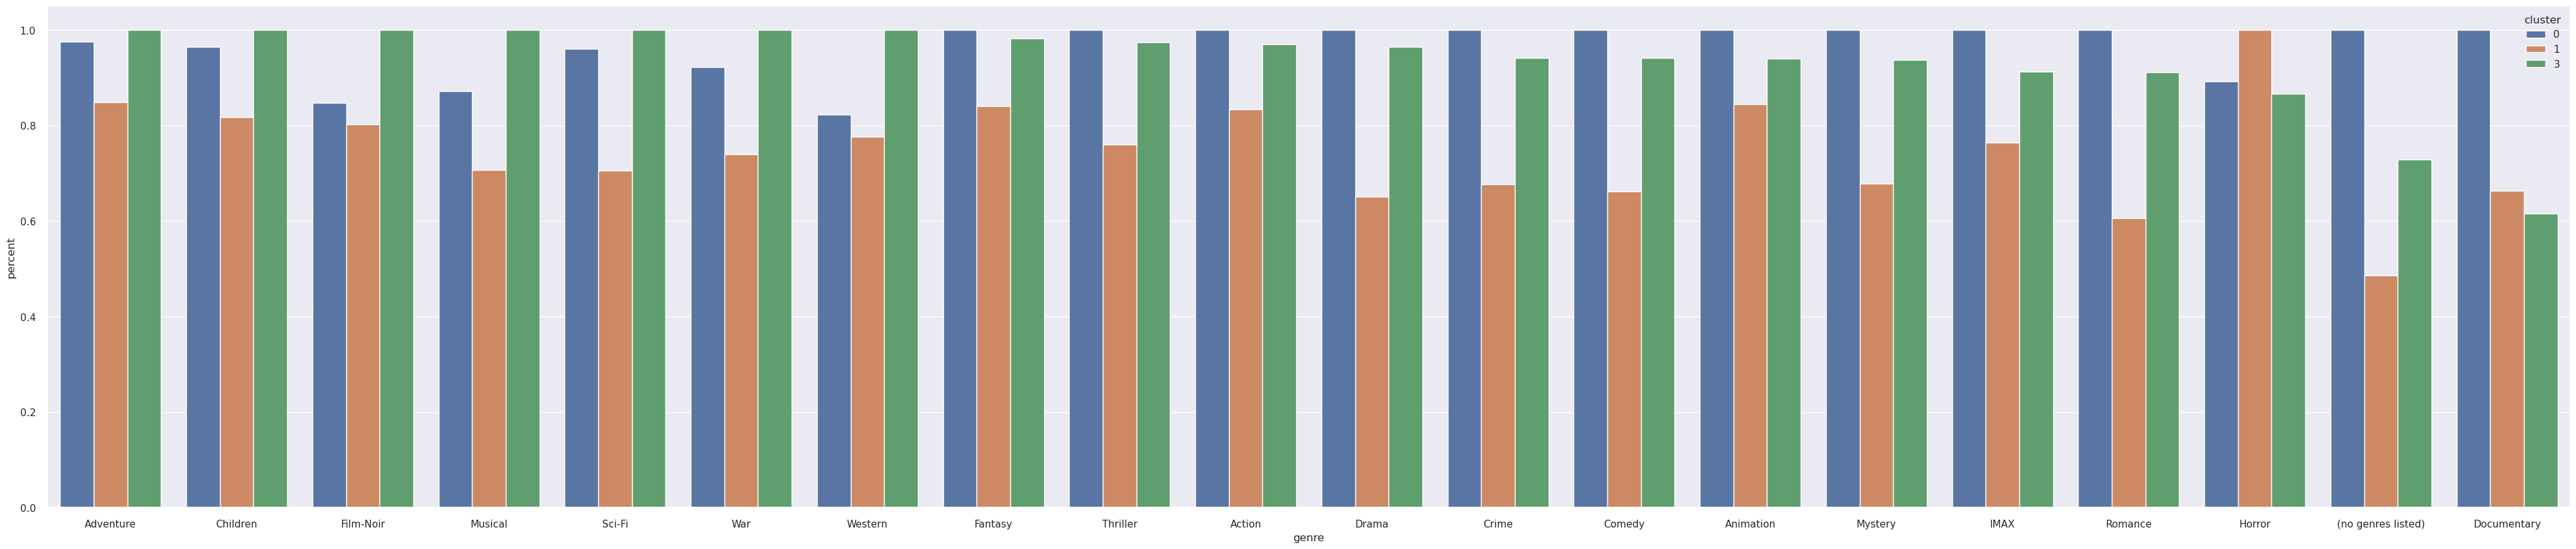

In [200]:
sns.set(rc={'figure.figsize':(50,10)})
sns.barplot(
    x="genre",
    y="percent",
    hue="cluster",
    data=data
)
plt.show()



### Cluster 0

Le gana a los demas clusters en:
    
* Documentales
* Romance
* IMAX
* Mistery
* Animation
* Comedy
* Crime
* Drame
* Action
* Thiller
* Fantasy

### Cluster 1
    
* Le gana a los demas clusters en: Horror.
* Mayor a 0.8: Adventure, Children, Fantasy, Action, Animation. 


### Cluster 3

Le gana a los demas clusters en:

* Adventure
* Children
* Film-Noir
* Musical
* Sci-Fi
* War
* Wester